# Deep Learning Fixed_month


In [1]:
"""

@ author: Taehyeong Kim, Fusion Data Analytics and Artificial Intelligence Lab

"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras

from keras.models import Input, Model, load_model
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import random

SEED=1011

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/AsiaSim_IJIE/M4/data/sample_data_day_2000.xlsx")
data.head()

,NIIN,201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112,201201,201202,201203,201204,201205,201206,201207,201208,201209,201210,201211,201212,201301,201302,201303,...,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,10.0,63.0,NaN,NaN,30.0,NaN,NaN,NaN,17.0,NaN,NaN,5.0,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2.0,11.0,10.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1,2,NaN,6.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,5.0,NaN,20.0,0.0,24.0,NaN,6.0,24.0,NaN,1.0,NaN,5.0,16.0,NaN,10.0,NaN,NaN,1.0,6.0,3.0,12.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,40.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,27.0,NaN,NaN,NaN,NaN,10.0,NaN,31.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


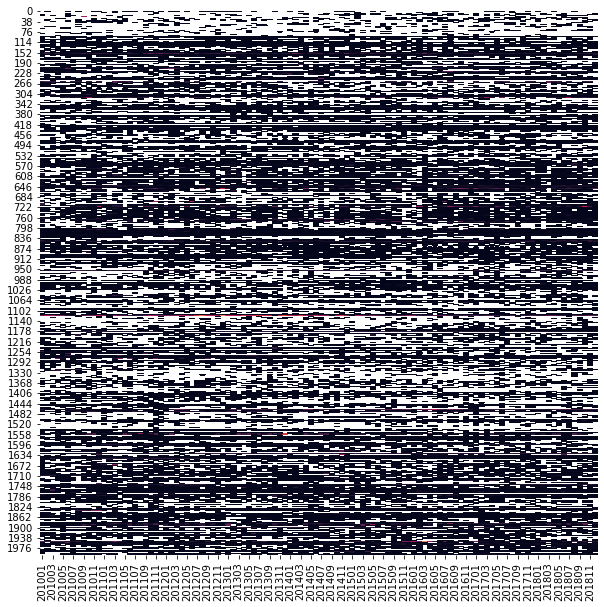

In [2]:
data=data.drop("NIIN", axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(data, cbar=False)
plt.show()

In [3]:
data=data.fillna(0)
float_columns=[]
for _ in data.T.columns:
    if np.mean(data.T[_]!=data.T[_].astype("int"))==True:
        float_columns.append(_)
data.T[float_columns]

,179,808,1178
201001,0.36,0.04,4.30
201002,0.57,0.20,6.17
201003,0.96,0.16,8.42
201004,1.55,0.07,9.56
201005,14.01,1.11,8.50
...,...,...,...
201808,2.81,0.30,0.70
201809,4.80,0.41,0.29
201810,2.85,1.26,0.38
201811,7.02,0.16,0.44


In [4]:
train = data.iloc[:,:-12]
test = data.iloc[:,12:]

train.shape, test.shape

((2000, 96), (2000, 96))

In [5]:
X_train, y_train = train.iloc[:, :-12], train.iloc[:, -12:]
X_test, y_test = test.iloc[:, :-12], test.iloc[:, -12:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 84), (2000, 12), (2000, 84), (2000, 12))

## 1. Machine Learning

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

In [7]:
estimator1 = LinearRegression(n_jobs=-1)
estimator2 = Ridge(random_state = SEED)
estimator3 = Lasso(random_state = SEED)
estimator4 = ElasticNet(random_state = SEED)
estimator5 = KNeighborsRegressor(n_jobs = -1)
estimator6 = DecisionTreeRegressor(random_state = SEED)
estimator7 = RandomForestRegressor(n_jobs=-1, random_state = SEED)

base_estimators = [estimator1, estimator2, estimator3, estimator4, estimator5, estimator6, estimator7]
model_name = ["LR", "Ridge", "Lasso", "Elastic", "KNN", "DT", "RF"]

for estimator, name in zip(base_estimators, model_name):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("==========")
    print("{0} model MAE is {1}".format(name, mae))
    print("{0} model RMSE is {1}".format(name, rmse))
    print("==========")

LR model MAE is 3.1422888278484233
LR model RMSE is 12.135338591027304
Ridge model MAE is 3.14223582362076
Ridge model RMSE is 12.135141696515094
Lasso model MAE is 2.6185417904558093
Lasso model RMSE is 10.316651336040508
Elastic model MAE is 2.7859432081395266
Elastic model RMSE is 10.843798950546258
KNN model MAE is 1.9316726666666624
KNN model RMSE is 8.972139797487925
DT model MAE is 2.622322461277521
DT model RMSE is 12.321507163786231
RF model MAE is 2.1072485203613076
RF model RMSE is 9.112762493775724


In [8]:
y_pred = estimator.predict(X_test)
pd.DataFrame(y_pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.68100,1.627600,2.732000,2.229300,0.452200,0.685100,2.685400,2.245200,1.396000,0.374800,1.394800,1.828600
1,5.15260,1.721500,4.895800,3.915500,4.981600,5.681600,4.506700,4.687800,5.169200,2.831200,4.204400,6.174500
2,0.01000,0.002604,0.007812,0.002188,0.515915,0.001771,0.015938,0.000417,0.000313,0.001771,0.000625,0.001146
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.49562,0.088904,0.265850,0.064353,0.310346,0.151236,0.465886,0.039910,0.023830,0.074714,0.104493,0.323413
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.84660,0.160200,0.602000,0.372300,0.400600,0.536700,0.312300,0.334000,0.420000,0.222800,0.420000,1.008700
1996,0.73580,1.456500,1.441600,0.787200,1.233200,0.568000,3.249400,1.599300,1.139600,0.436500,0.768500,1.072600
1997,5.87160,7.758800,14.703500,8.145700,10.161700,9.128800,10.007000,7.470100,9.344100,7.910800,7.558600,8.397400
1998,15.77020,12.843200,23.260400,15.857300,16.309700,17.835100,15.747500,15.315900,14.898200,13.188200,11.070900,11.791000


## 2. Deep Learning

In [9]:
BATCH_SIZE=512
EPOCHS=200

### 2.1 MLP

In [10]:
inputs = Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5440      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

Epoch 1/200
4/4 [==============================] - 3s 127ms/step - loss: 387.6390 - mae: 3.9552 - val_loss: 228.4482 - val_mae: 4.6169
Epoch 2/200
4/4 [==============================] - 0s 12ms/step - loss: 264.1034 - mae: 3.4514 - val_loss: 212.4922 - val_mae: 4.3210
Epoch 3/200
4/4 [==============================] - 0s 12ms/step - loss: 227.4090 - mae: 3.2438 - val_loss: 202.8041 - val_mae: 4.1362
Epoch 4/200
4/4 [==============================] - 0s 12ms/step - loss: 223.5144 - mae: 3.1439 - val_loss: 194.8446 - val_mae: 4.0027
Epoch 5/200
4/4 [==============================] - 0s 13ms/step - loss: 206.8982 - mae: 3.0086 - val_loss: 186.2370 - val_mae: 3.9042
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 185.8493 - mae: 2.8730 - val_loss: 178.9518 - val_mae: 3.8316
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 205.3095 - mae: 2.9006 - val_loss: 172.6351 - val_mae: 3.7763
Epoch 8/200
4/4 [==============================] - 0s 10ms/st

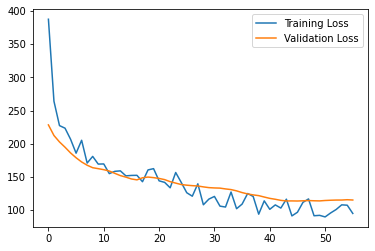

In [11]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="mlp.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("mlp.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("MLP", mae))
print("{0} model RMSE is {1}".format("MLP", rmse))

MLP model MAE is 2.3223980212766424
MLP model RMSE is 10.20592827469939


### 2.2 RNN

In [13]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.SimpleRNN(64)(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
layer_normalization (LayerNo (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)                396       
Total params: 6,828
Trainable params: 6,828
Non-trainable params: 0
_________________________________________________________

Epoch 1/200
4/4 [==============================] - 4s 183ms/step - loss: 182.0484 - mae: 2.8893 - val_loss: 197.0043 - val_mae: 3.7527
Epoch 2/200
4/4 [==============================] - 0s 96ms/step - loss: 180.7073 - mae: 2.8063 - val_loss: 195.1038 - val_mae: 3.6967
Epoch 3/200
4/4 [==============================] - 0s 87ms/step - loss: 178.7021 - mae: 2.7393 - val_loss: 193.2471 - val_mae: 3.6249
Epoch 4/200
4/4 [==============================] - 0s 92ms/step - loss: 177.6263 - mae: 2.6651 - val_loss: 191.1916 - val_mae: 3.5707
Epoch 5/200
4/4 [==============================] - 0s 96ms/step - loss: 176.1041 - mae: 2.6089 - val_loss: 189.0228 - val_mae: 3.5590
Epoch 6/200
4/4 [==============================] - 0s 88ms/step - loss: 174.6262 - mae: 2.5847 - val_loss: 186.7489 - val_mae: 3.5084
Epoch 7/200
4/4 [==============================] - 0s 84ms/step - loss: 173.0311 - mae: 2.5519 - val_loss: 184.4035 - val_mae: 3.5239
Epoch 8/200
4/4 [==============================] - 0s 89ms/st

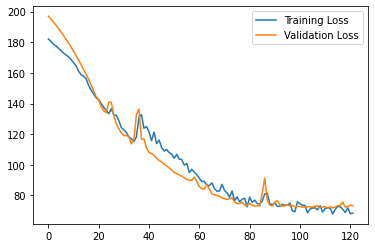

In [14]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="rnn.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("rnn.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("RNN", mae))
print("{0} model RMSE is {1}".format("RNN", rmse))

RNN model MAE is 2.009687277671092
RNN model RMSE is 9.36495854443231


### 2.3 LSTM

In [16]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.LSTM(64)(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 84, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
layer_normalization_1 (Layer (None, 64)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                396       
Total params: 19,500
Trainable params: 19,500
Non-trainable params: 0
_______________________________________________________

Epoch 1/200
4/4 [==============================] - 3s 203ms/step - loss: 182.7458 - mae: 2.5126 - val_loss: 199.4244 - val_mae: 3.5820
Epoch 2/200
4/4 [==============================] - 0s 32ms/step - loss: 181.6727 - mae: 2.5397 - val_loss: 198.1297 - val_mae: 3.5763
Epoch 3/200
4/4 [==============================] - 0s 32ms/step - loss: 180.4825 - mae: 2.5201 - val_loss: 196.8754 - val_mae: 3.5461
Epoch 4/200
4/4 [==============================] - 0s 33ms/step - loss: 179.3388 - mae: 2.4993 - val_loss: 195.5328 - val_mae: 3.5228
Epoch 5/200
4/4 [==============================] - 0s 32ms/step - loss: 178.5396 - mae: 2.4855 - val_loss: 194.1124 - val_mae: 3.5039
Epoch 6/200
4/4 [==============================] - 0s 32ms/step - loss: 177.5226 - mae: 2.4705 - val_loss: 192.6002 - val_mae: 3.4795
Epoch 7/200
4/4 [==============================] - 0s 31ms/step - loss: 175.7074 - mae: 2.4452 - val_loss: 190.8579 - val_mae: 3.4663
Epoch 8/200
4/4 [==============================] - 0s 31ms/st

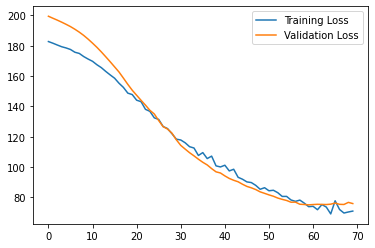

In [17]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="lstm.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("lstm.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("LSTM", mae))
print("{0} model RMSE is {1}".format("LSTM", rmse))

LSTM model MAE is 2.0807666683205466
LSTM model RMSE is 9.423791421909838


### 2.4 GRU

In [19]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.GRU(64)(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 84, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
layer_normalization_2 (Layer (None, 64)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                396       
Total params: 15,468
Trainable params: 15,468
Non-trainable params: 0
_______________________________________________________

Epoch 1/200
4/4 [==============================] - 3s 200ms/step - loss: 185.4028 - mae: 2.5591 - val_loss: 202.4098 - val_mae: 3.5995
Epoch 2/200
4/4 [==============================] - 0s 32ms/step - loss: 183.5309 - mae: 2.5512 - val_loss: 200.5091 - val_mae: 3.5803
Epoch 3/200
4/4 [==============================] - 0s 31ms/step - loss: 182.2989 - mae: 2.5361 - val_loss: 198.8364 - val_mae: 3.5705
Epoch 4/200
4/4 [==============================] - 0s 31ms/step - loss: 181.3127 - mae: 2.5430 - val_loss: 197.2286 - val_mae: 3.5690
Epoch 5/200
4/4 [==============================] - 0s 32ms/step - loss: 180.0818 - mae: 2.5477 - val_loss: 195.7011 - val_mae: 3.5612
Epoch 6/200
4/4 [==============================] - 0s 31ms/step - loss: 178.9717 - mae: 2.5559 - val_loss: 194.1986 - val_mae: 3.5557
Epoch 7/200
4/4 [==============================] - 0s 32ms/step - loss: 177.9582 - mae: 2.5602 - val_loss: 192.6819 - val_mae: 3.5515
Epoch 8/200
4/4 [==============================] - 0s 31ms/st

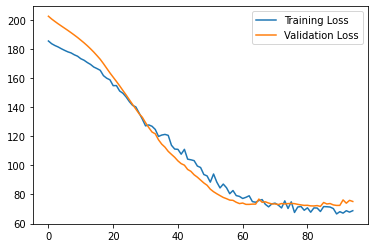

In [20]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="gru.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("gru.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("GRU", mae))
print("{0} model RMSE is {1}".format("GRU", rmse))

GRU model MAE is 2.0306486180280143
GRU model RMSE is 9.29773316174443


## 3. Attention

In [22]:
from tensorflow.keras import backend as K

def attention_3d_block(inputs):
    
    input_dim = int(inputs.shape[2])                      # input shape = (batch_size, time_steps, input_dim)
    att = layers.Dense(1, activation='tanh')(inputs)      # shape = batch * time_steps * 1
    att = layers.Flatten()(att)                           # shape = batch * time_steps
    att = layers.Activation('softmax')(att)               # shape = batch * time_steps
    att = layers.RepeatVector(input_dim)(att)             # shape = batch * input_dim * time_steps
    att = layers.Permute([2, 1])(att)                     # shape = batch * time_step * input_dim
    att = layers.Multiply()([inputs, att])                # shape = batch * time_step * input_dim
    att = layers.Lambda(lambda x: K.sum(x, axis=-2),
                        output_shape=(input_dim,))(att)   # shape = batch * input_dim

    return att

### 3.1 Attention RNN

In [23]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.LayerNormalization()(x)
x = attention_3d_block(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 84, 1)]      0                                            
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 84, 64)       4224        input_5[0][0]                    
__________________________________________________________________________________________________
layer_normalization_3 (LayerNor (None, 84, 64)       128         simple_rnn_1[0][0]               
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 84, 1)        65          layer_normalization_3[0][0]      
____________________________________________________________________________________________

Epoch 1/200
4/4 [==============================] - 2s 296ms/step - loss: 184.0520 - mae: 2.5280 - val_loss: 201.7804 - val_mae: 3.5626
Epoch 2/200
1/4 [======>.......................] - ETA: 0s - loss: 171.0564 - mae: 2.3844

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


4/4 [==============================] - 0s 94ms/step - loss: 183.1212 - mae: 2.4838 - val_loss: 200.4090 - val_mae: 3.5553
Epoch 3/200
4/4 [==============================] - 0s 99ms/step - loss: 182.0254 - mae: 2.4784 - val_loss: 198.9291 - val_mae: 3.5563
Epoch 4/200
4/4 [==============================] - 0s 93ms/step - loss: 181.0015 - mae: 2.4821 - val_loss: 197.3817 - val_mae: 3.5609
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 179.9510 - mae: 2.4829 - val_loss: 195.9149 - val_mae: 3.5697
Epoch 6/200
4/4 [==============================] - 0s 99ms/step - loss: 179.0238 - mae: 2.4815 - val_loss: 194.5086 - val_mae: 3.5557
Epoch 7/200
4/4 [==============================] - 0s 94ms/step - loss: 177.6966 - mae: 2.4728 - val_loss: 193.0224 - val_mae: 3.5536
Epoch 8/200
4/4 [==============================] - 0s 97ms/step - loss: 176.7296 - mae: 2.4722 - val_loss: 191.4028 - val_mae: 3.5617
Epoch 9/200
4/4 [==============================] - 0s 103ms/step - loss: 1

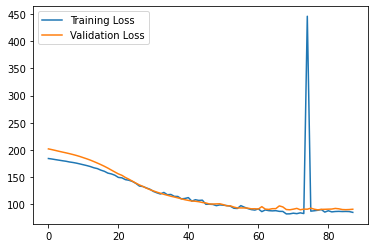

In [24]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="att_rnn.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("att_rnn.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("Att-RNN", mae))
print("{0} model RMSE is {1}".format("Att-RNN", rmse))

Att-RNN model MAE is 2.2589155337405886
Att-RNN model RMSE is 9.429129787790941


### 3.2 Attention LSTM

In [26]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LayerNormalization()(x)
x = attention_3d_block(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 84, 1)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 84, 64)       16896       input_6[0][0]                    
__________________________________________________________________________________________________
layer_normalization_4 (LayerNor (None, 84, 64)       128         lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 84, 1)        65          layer_normalization_4[0][0]      
____________________________________________________________________________________________

Epoch 1/200
4/4 [==============================] - 3s 243ms/step - loss: 183.2222 - mae: 2.5286 - val_loss: 198.4967 - val_mae: 3.5904
Epoch 2/200
3/4 [=====================>........] - ETA: 0s - loss: 188.6214 - mae: 2.6333

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


4/4 [==============================] - 0s 51ms/step - loss: 181.3557 - mae: 2.5665 - val_loss: 196.2114 - val_mae: 3.6338
Epoch 3/200
4/4 [==============================] - 0s 47ms/step - loss: 179.6118 - mae: 2.5774 - val_loss: 194.3204 - val_mae: 3.6365
Epoch 4/200
4/4 [==============================] - 0s 46ms/step - loss: 178.3590 - mae: 2.5727 - val_loss: 192.4210 - val_mae: 3.6590
Epoch 5/200
4/4 [==============================] - 0s 46ms/step - loss: 177.4323 - mae: 2.5743 - val_loss: 190.5870 - val_mae: 3.6792
Epoch 6/200
4/4 [==============================] - 0s 46ms/step - loss: 175.6222 - mae: 2.5520 - val_loss: 188.7470 - val_mae: 3.6440
Epoch 7/200
4/4 [==============================] - 0s 44ms/step - loss: 174.1372 - mae: 2.5244 - val_loss: 186.7750 - val_mae: 3.6107
Epoch 8/200
4/4 [==============================] - 0s 44ms/step - loss: 173.0346 - mae: 2.4883 - val_loss: 184.7425 - val_mae: 3.5743
Epoch 9/200
4/4 [==============================] - 0s 43ms/step - loss: 17

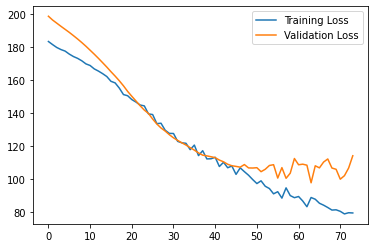

In [27]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="att_lstm.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("att_lstm.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("Att-LSTM", mae))
print("{0} model RMSE is {1}".format("Att-LSTM", rmse))

Att-LSTM model MAE is 2.1454342976552803
Att-LSTM model RMSE is 9.478111180104579


### 3.3 Attention GRU

In [29]:
inputs = Input(shape=(X_train.shape[1], 1))
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.LayerNormalization()(x)
x = attention_3d_block(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(12, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 84, 1)]      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 84, 64)       12864       input_7[0][0]                    
__________________________________________________________________________________________________
layer_normalization_5 (LayerNor (None, 84, 64)       128         gru_1[0][0]                      
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 84, 1)        65          layer_normalization_5[0][0]      
____________________________________________________________________________________________

Epoch 1/200
4/4 [==============================] - 3s 229ms/step - loss: 184.9955 - mae: 2.4844 - val_loss: 202.7412 - val_mae: 3.5307
Epoch 2/200
3/4 [=====================>........] - ETA: 0s - loss: 191.2744 - mae: 2.5436

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


4/4 [==============================] - 0s 47ms/step - loss: 183.9274 - mae: 2.4758 - val_loss: 201.4996 - val_mae: 3.5542
Epoch 3/200
4/4 [==============================] - 0s 45ms/step - loss: 183.1124 - mae: 2.5218 - val_loss: 200.3405 - val_mae: 3.5964
Epoch 4/200
4/4 [==============================] - 0s 45ms/step - loss: 182.2991 - mae: 2.5787 - val_loss: 199.1423 - val_mae: 3.6317
Epoch 5/200
4/4 [==============================] - 0s 45ms/step - loss: 181.4223 - mae: 2.6061 - val_loss: 197.9354 - val_mae: 3.6580
Epoch 6/200
4/4 [==============================] - 0s 46ms/step - loss: 180.5382 - mae: 2.6175 - val_loss: 196.5545 - val_mae: 3.6830
Epoch 7/200
4/4 [==============================] - 0s 44ms/step - loss: 179.4417 - mae: 2.6570 - val_loss: 194.9734 - val_mae: 3.7558
Epoch 8/200
4/4 [==============================] - 0s 46ms/step - loss: 178.4665 - mae: 2.6978 - val_loss: 193.1872 - val_mae: 3.7493
Epoch 9/200
4/4 [==============================] - 0s 46ms/step - loss: 17

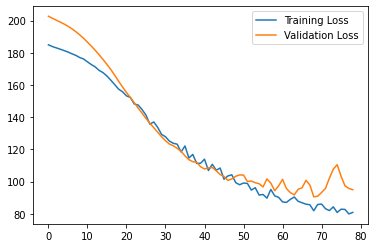

In [30]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics="mae")

callbacks_list = [
    
    ModelCheckpoint(filepath="att_gru.h5", 
                    verbose=0,
                    save_best_only=True),

    EarlyStopping(monitor='val_loss', patience=10)
    
]

history = model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2)

model = load_model("att_gru.h5")

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [31]:
y_pred = model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("{0} model MAE is {1}".format("Att-GRU", mae))
print("{0} model RMSE is {1}".format("Att-GRU", rmse))

Att-GRU model MAE is 2.0048692567125954
Att-GRU model RMSE is 9.35630186490883
